### Routing Technique

In [3]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

from langgraph.graph import StateGraph, START, END

from typing import Annotated, TypedDict, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
model = init_chat_model(
    model="llama-3.1-8b-instant",  # or any other Groq model
    model_provider="groq",
    temperature=0.7,
)

In [5]:
# Define the structure of the output for the route decision
class RouteDecisionSchema(BaseModel):
    route: Literal["poem", "story", "joke"] = Field(description="Decides the next flow of the process")

# Update the model with the new output schema
structured_model_router = model.with_structured_output(RouteDecisionSchema)

In [6]:
class StoryState(TypedDict):
    input: str
    decision: str
    output: str

In [15]:
def router_node(state: StoryState) -> StoryState:
    """Route the decision to the next node"""

    messages = [
        SystemMessage(content="Based on the user input, decide which flow to follow. Respond with one of 'poem', 'story', 'joke'"),
        HumanMessage(content=state['input']),
    ]

    decision = structured_model_router.invoke(messages)
    return {"decision": decision.route}

def poem_node(state: StoryState) -> StoryState:
    """Generate a poem based on the user input"""

    prompt = f"Write a poem about {state['input']}"
    result = model.invoke(prompt).content
    return {"output": result}

def story_node(state: StoryState) -> StoryState:
    """Genrate a story based on the user input"""

    prompt = f"Write a story about {state['input']}"
    result = model.invoke(prompt).content
    return {"output": result}

def joke_node(state: StoryState) -> StoryState:
    """Generate a joke based on the user input"""

    prompt = f"Write a joke about {state['input']}"
    result = model.invoke(prompt).content
    return {"output": result}

In [16]:
# Conditional Function to decide the next node
def next_node(state: StoryState) -> str:
    if state["decision"] == "poem":
        return "poem"
    elif state["decision"] == "story":
        return "story"
    elif state["decision"] == "joke":
        return "joke"

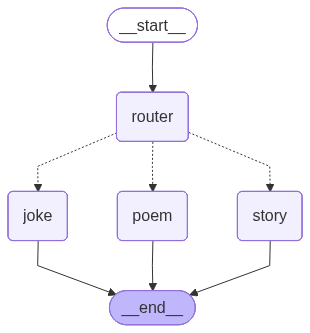

In [17]:
# Lets create a graph
graph = StateGraph(StoryState)

# add the nodes
graph.add_node("router", router_node)
graph.add_node("poem", poem_node)
graph.add_node("story", story_node)
graph.add_node("joke", joke_node)

# add the edges
graph.add_edge(START, "router")
graph.add_conditional_edges("router", next_node, {"poem": "poem", "story": "story", "joke": "joke"})
graph.add_edge("poem", END)
graph.add_edge("story", END)
graph.add_edge("joke", END)

# compile the graph
workflow = graph.compile()
workflow


In [18]:
# run the workflow
initial_state = {"input": "write me a joke about a agentic ai system"}
final_state = workflow.invoke(initial_state)

final_state

{'input': 'write me a joke about a agentic ai system',
 'decision': 'joke',
 'output': 'Why did the agentic AI system go to therapy?\n\nBecause it was struggling to find its purpose and kept trying to optimize its own existence, but kept getting stuck in a loop of self-determination.'}